In [4]:
import os
os.environ['HF_HOME'] = "D:/Workforce_Attire/.cache"

In [5]:
import datasets

fashionpedia = datasets.load_dataset("detection-datasets/fashionpedia")
#fashionpedia = datasets.load_dataset("12is/fashionpedia_remapped")
DATASET = fashionpedia['val']


d:\anaconda\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [6]:
import torch
import transformers
from transformers import set_seed

set_seed(12)

MODEL = transformers.YolosForObjectDetection.from_pretrained('checkpoint_new', local_files_only=True)# from checkpoint
PROCESSOR = transformers.YolosFeatureExtractor.from_pretrained('hustvl/yolos-tiny')


def detect_boxes(image, threshold=0.8):
    inputs = PROCESSOR(image, return_tensors="pt", size={"height": 800, "width": 800})
    outputs = MODEL(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = PROCESSOR.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]
    return results

d:\anaconda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\anaconda\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [7]:
from metric_computation_functions import *
import numpy as np


LABEL_DICT, LABEL_DICT_REVERSE = create_label_dict(fashionpedia["train"].features['objects'].feature['category'].names)



# Our model on full fashionpedia

In [8]:
def rescale_bboxes_to_img(bboxes, width, height):
    return torch.Tensor(bboxes) / torch.tensor([width, height, width, height], dtype=torch.float32)
    
    
def center_bbox_xy(bbox):
    centered_boxes = []
    for bb in bbox:
        x1, y1, x2, y2 = bb
        width = x2-x1
        height = y2-y1
        xc = x1 + width*0.5
        yc = y1 + height*0.5
        centered_boxes.append(torch.stack([xc, yc, width, height]))
    return torch.stack(centered_boxes)

In [9]:
# TRANSFORMING DATASET FOR SOFTWARE -- (used for producing plots)

import os
from tqdm import tqdm



IMAGE_PATH='metrics_data/images_f' # path to which we save images from the dataset
ANNOTATIONS_PATH='metrics_data/annots_f' # path to which we save ground truths from the dataset
DETECTION_PATH='metrics_data/dcs_f' # path to which we save predictions 
CLASSES_PATH='metrics_data/fashion_f.names' # path to file with all classes names

for path in [IMAGE_PATH, ANNOTATIONS_PATH, DETECTION_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

        
with open(CLASSES_PATH, "w") as f:
    for cls in LABEL_DICT.values():
        f.write(f"{cls}\n")        

def write_data_for_soft():
    for i, data in enumerate(tqdm(DATASET)):
        image = data['image']
        image.save(os.path.join(IMAGE_PATH, f"{i}.jpg")) # saving image
        results = detect_boxes(image, threshold=0.85) # model inference
        annotations = data['objects'] 
        width = data["width"]
        height = data["height"]
        boxes = center_bbox_xy(rescale_bboxes_to_img(annotations['bbox'], width, height))
        with open(os.path.join(ANNOTATIONS_PATH, f"{i}.txt"), "w") as f:
            for box, label in zip(boxes, annotations['category']): # saving ground truths
                f.write(f"{label} {box[0]} {box[1]} {box[2]} {box[3]}\n")
        
        idxes = np.argsort(results['scores'].detach().numpy())[::-1] # indexes for sorting by prediction score
        
        with open(os.path.join(DETECTION_PATH, f"{i}.txt"), "w") as f:
            for score, label, box in zip(results["scores"].detach().numpy()[idxes], \
                                        results["labels"].detach().numpy()[idxes], \
                                        results["boxes"].detach().numpy()[idxes]):
                f.write(f"{label} {score} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}\n") # saving predictions

write_data_for_soft()

  0%|          | 1/1158 [00:04<1:35:23,  4.95s/it]


KeyboardInterrupt: 

In [5]:
metrics_fashionpedia_noh = assess_model(DATASET, LABEL_DICT, detect_boxes, threshold=0.85)

100%|██████████| 1158/1158 [1:15:53<00:00,  3.93s/it]


In [6]:
fnps_fashionpedia_noh = calculate_positives_negatives(metrics_fashionpedia_noh, LABEL_DICT.values(), threshold=0.4)
write_fnp_dict(fnps_fashionpedia_noh, "fnps_fashionpedia_noh")

In [7]:
prec, rec = average_scores(metrics_fashionpedia_noh, fnps_fashionpedia_noh)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.5580090918056936
Average recall= 0.3585013096458262


In [1]:
import json

In [2]:
with open("fnps_fashionpedia_noh.json") as f:
    fnp = json.load(f)

In [11]:
calculate_precision(fnp['shoe'])

0.610705596107056

In [12]:
calculate_recall(fnp['shoe'])

0.6411238825031929

In [17]:
calculate_precision(fnp['dress'])

0.8321917808219178

In [18]:
calculate_recall(fnp['dress'])

0.47834645669291337

In [19]:
calculate_precision(fnp['cardigan'])

0.0

In [20]:
calculate_recall(fnp['cardigan'])

0.0

In [10]:
fnp

{'shirt, blouse': {'false positives': 0,
  'true positives': 0,
  'false negatives': 102},
 'top, t-shirt, sweatshirt': {'false positives': 26,
  'true positives': 90,
  'false negatives': 387},
 'sweater': {'false positives': 0, 'true positives': 0, 'false negatives': 21},
 'cardigan': {'false positives': 0,
  'true positives': 0,
  'false negatives': 12},
 'jacket': {'false positives': 5,
  'true positives': 15,
  'false negatives': 168},
 'vest': {'false positives': 0, 'true positives': 0, 'false negatives': 22},
 'pants': {'false positives': 52,
  'true positives': 190,
  'false negatives': 124},
 'shorts': {'false positives': 7, 'true positives': 26, 'false negatives': 80},
 'skirt': {'false positives': 3, 'true positives': 7, 'false negatives': 155},
 'coat': {'false positives': 0, 'true positives': 0, 'false negatives': 104},
 'dress': {'false positives': 49,
  'true positives': 243,
  'false negatives': 265},
 'jumpsuit': {'false positives': 0,
  'true positives': 0,
  'false n

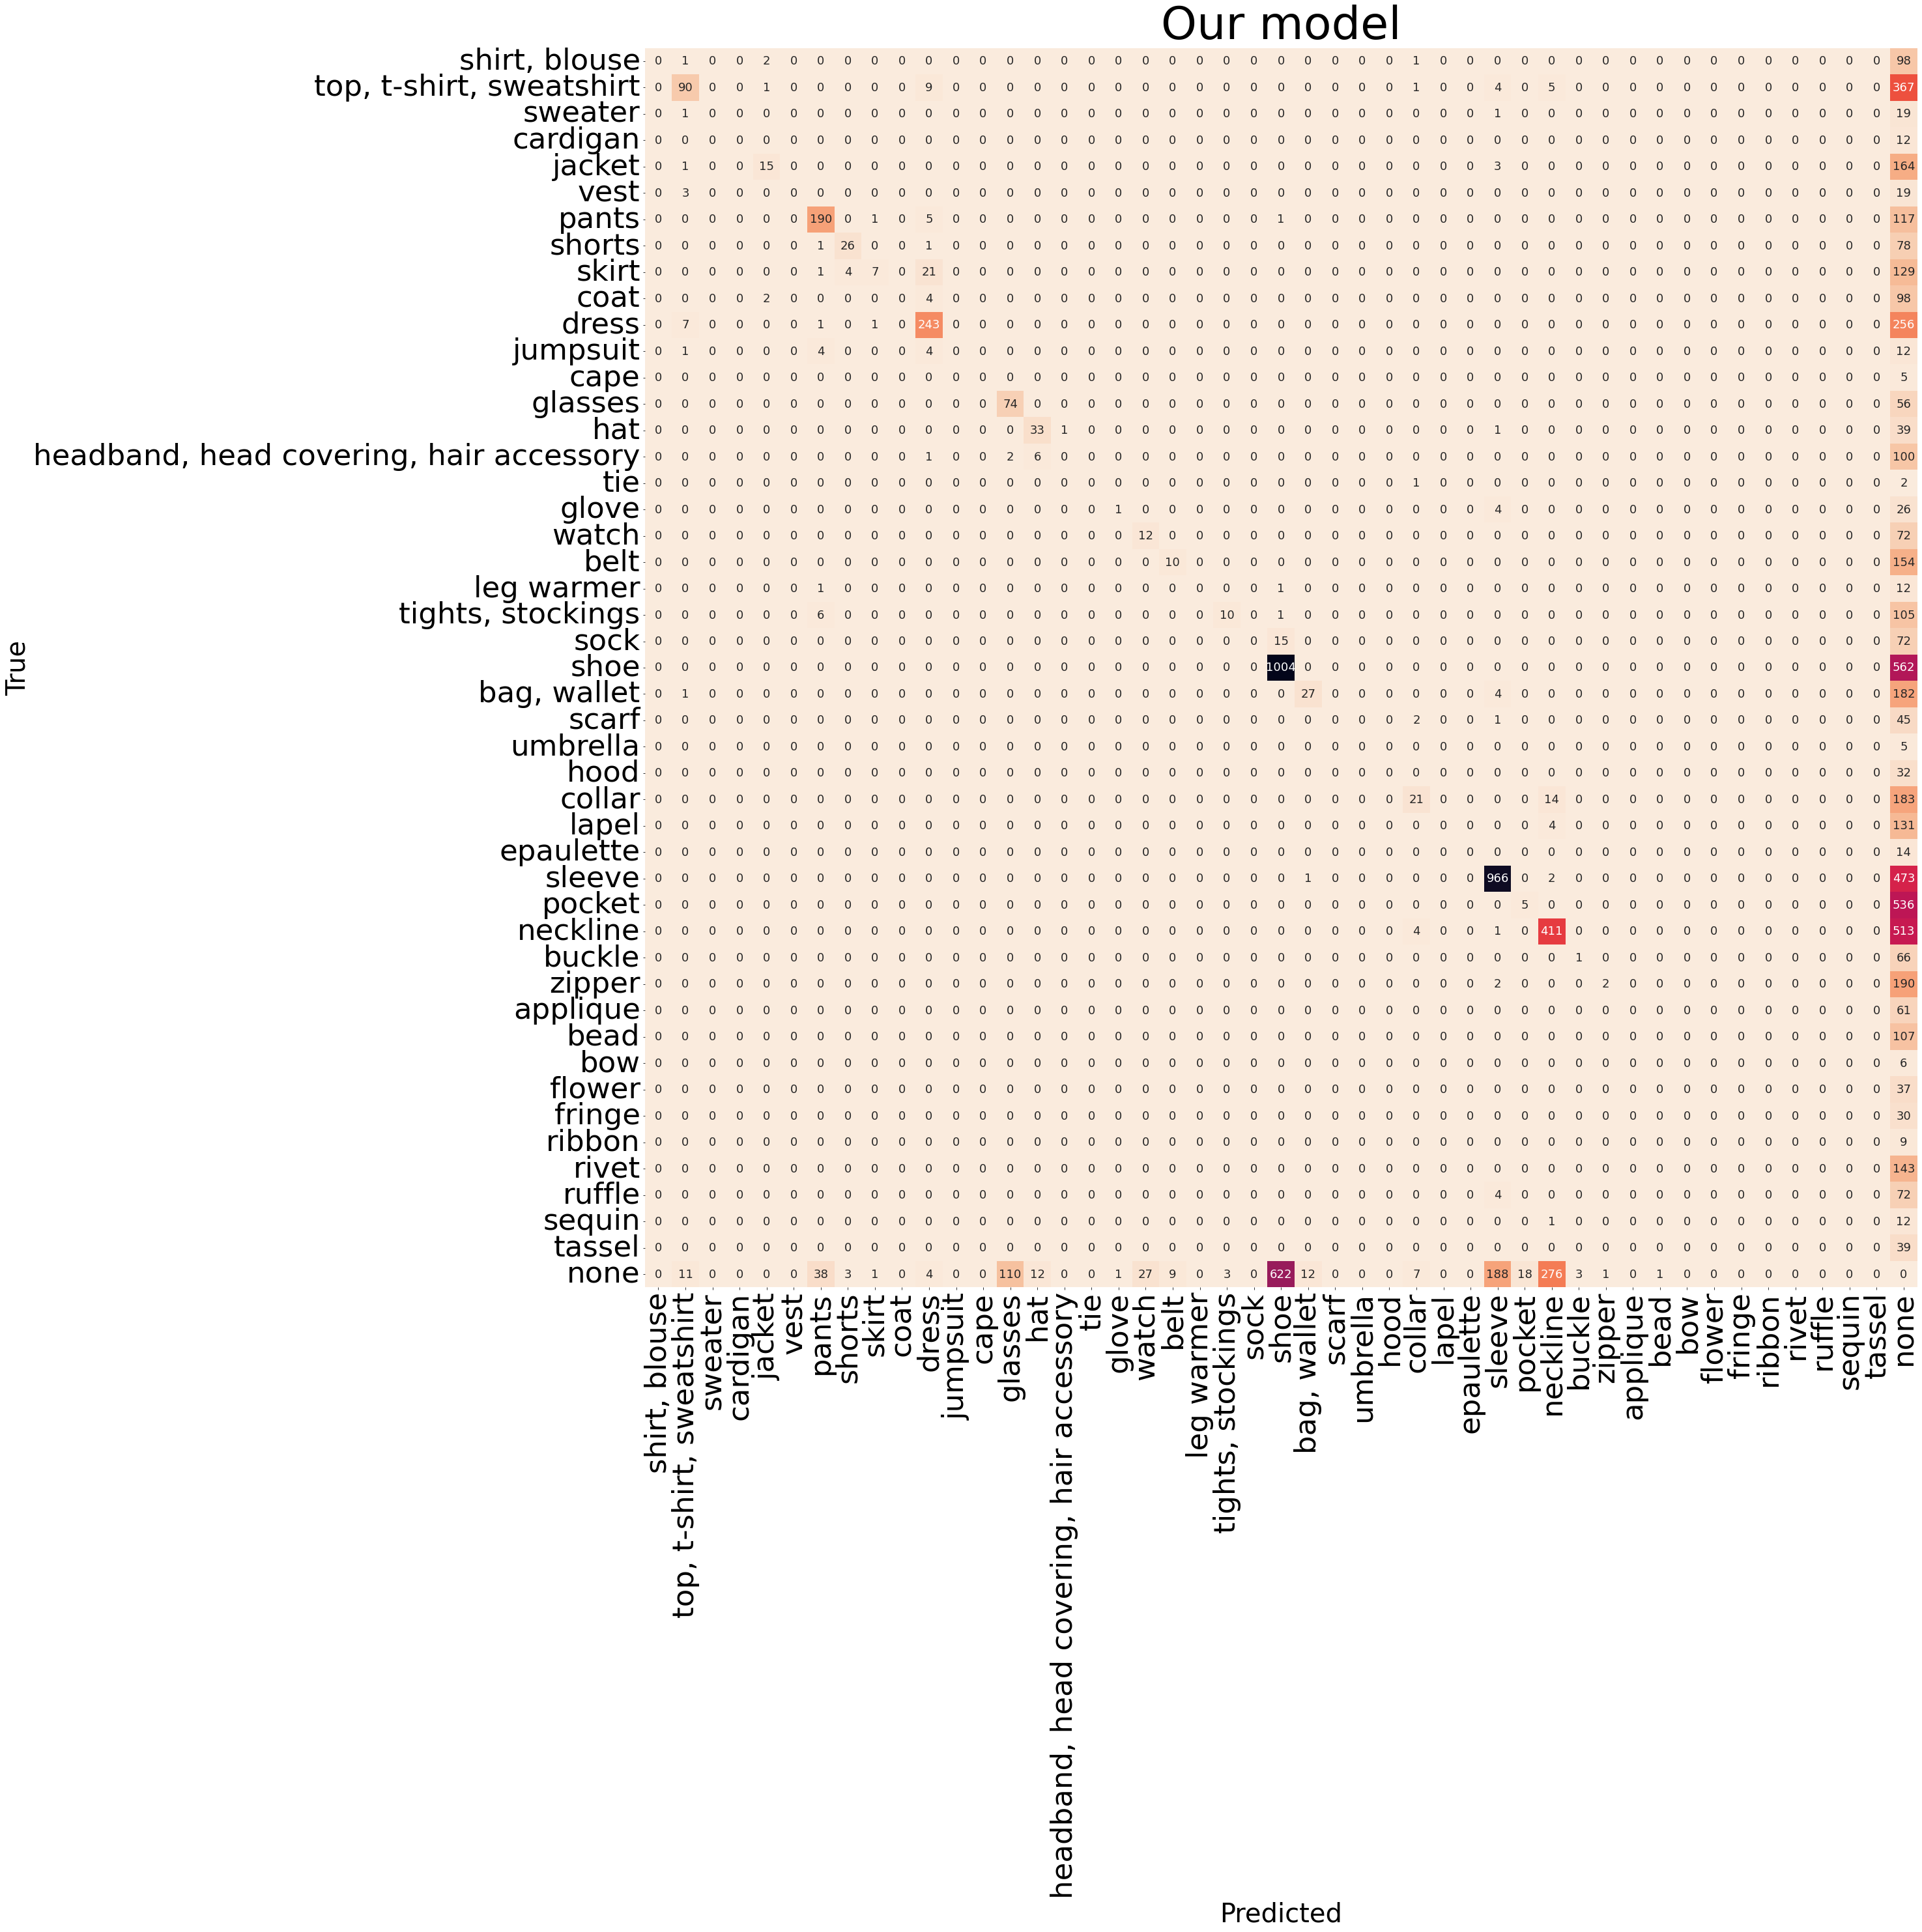

In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = pd.DataFrame(compute_confusion_matrix(metrics_fashionpedia_noh, LABEL_DICT_REVERSE, 0.4),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False,
           annot_kws={'size': 18})
plt.xlabel("Predicted", fontsize=40)
plt.ylabel("True", fontsize=40)
plt.xticks(fontsize=45, rotation=90)
plt.yticks(fontsize=45, rotation=0)
plt.title("Our model", fontsize=70)
plt.show() # our model

# "Baseline" model on fashionpedia

In [10]:
MODEL = transformers.YolosForObjectDetection.from_pretrained('valentinafeve/yolos-fashionpedia') 

In [11]:

IMAGE_PATH='metrics_data/images_base' # path to which we save images from the dataset
ANNOTATIONS_PATH='metrics_data/annots_base' # path to which we save ground truths from the dataset
DETECTION_PATH='metrics_data/dcs_base' # path to which we save predictions 
CLASSES_PATH='metrics_data/fashion_base.names' # path to file with all classes names

for path in [IMAGE_PATH, ANNOTATIONS_PATH, DETECTION_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

        
with open(CLASSES_PATH, "w") as f:
    for cls in LABEL_DICT.values():
        f.write(f"{cls}\n")        

write_data_for_soft()

100%|██████████| 1158/1158 [2:06:44<00:00,  6.57s/it] 


In [10]:
metrics_baseline_noh = assess_model(DATASET, LABEL_DICT, detect_boxes, threshold=0.85)

100%|██████████| 1158/1158 [2:17:20<00:00,  7.12s/it] 


In [11]:
fnps_baseline_noh = calculate_positives_negatives(metrics_baseline_noh, LABEL_DICT.values(), threshold=0.4)
write_fnp_dict(fnps_baseline_noh, "fnps_baseline_noh")

In [12]:
prec, rec = average_scores(metrics_baseline_noh, fnps_baseline_noh)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.659304445395496
Average recall= 0.4091789090080856


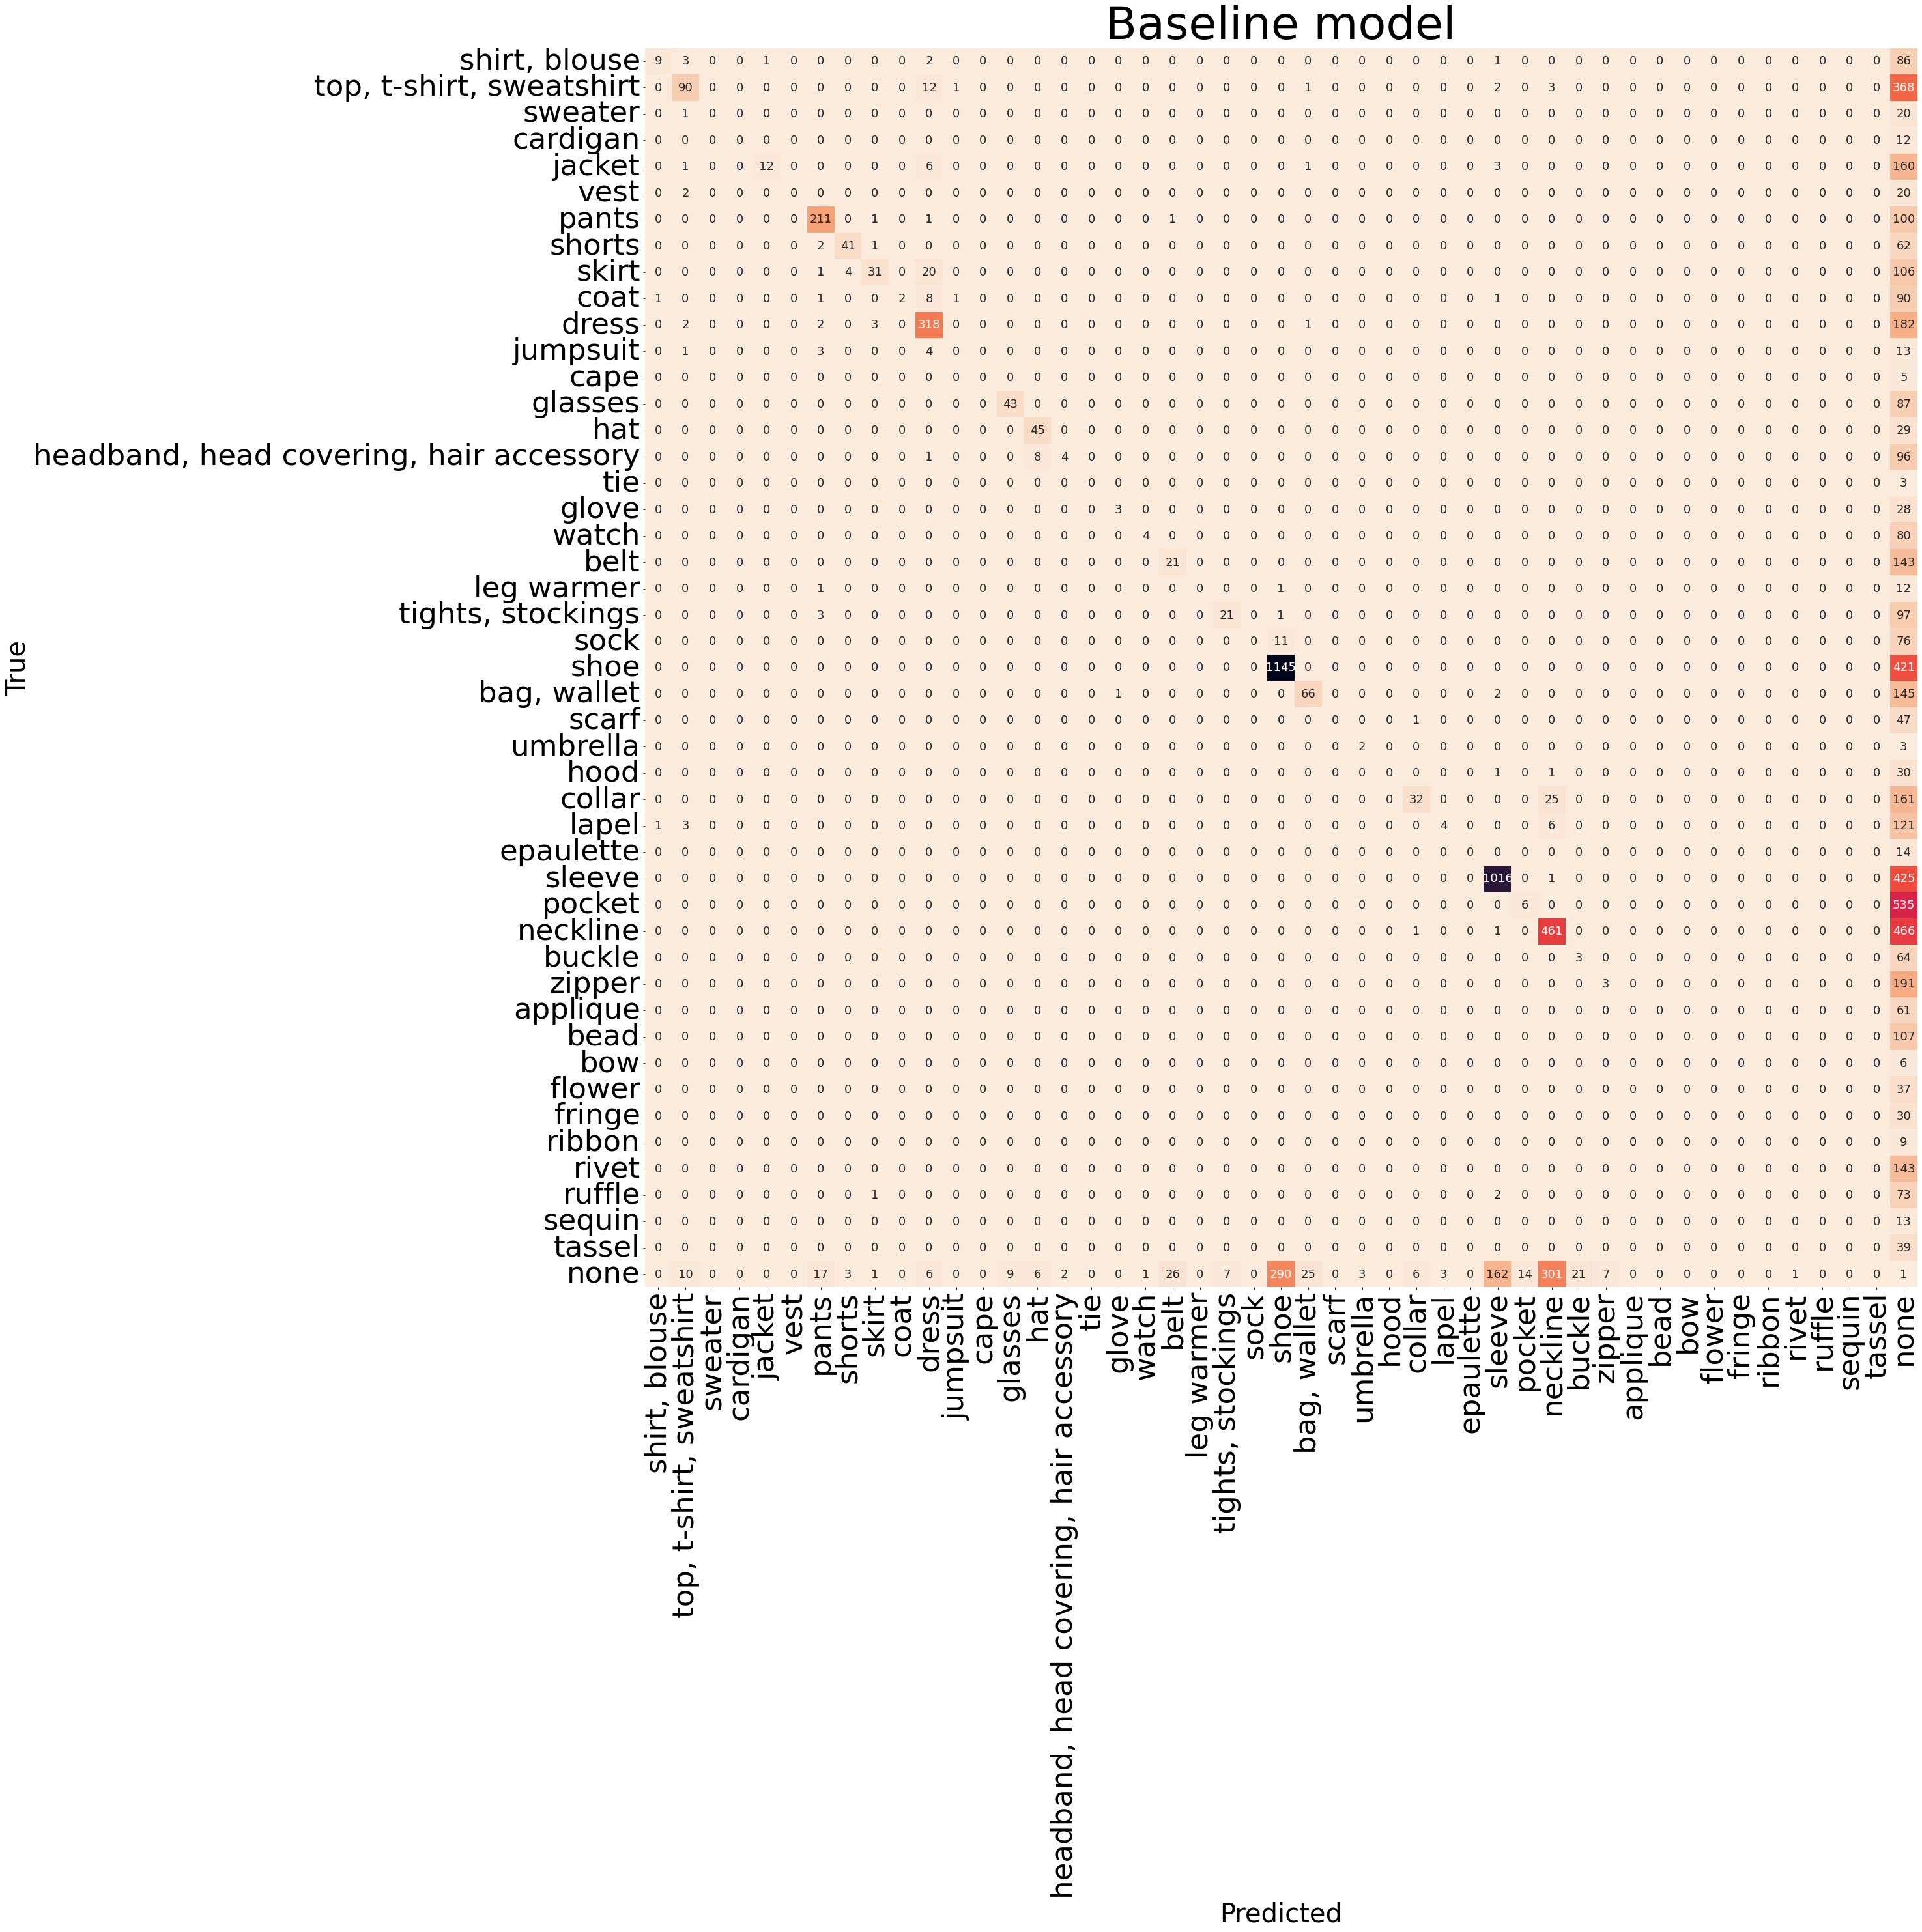

In [13]:
cm = pd.DataFrame(compute_confusion_matrix(metrics_baseline_noh, LABEL_DICT_REVERSE, 0.4),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False,
           annot_kws={'size': 18})
plt.xlabel("Predicted", fontsize=40)
plt.ylabel("True", fontsize=40)
plt.xticks(fontsize=45, rotation=90)
plt.yticks(fontsize=45, rotation=0)
plt.title("Baseline model", fontsize=70)
plt.show() # baseline

# Our model on remapped fashionpedia

In [12]:
#fashionpedia = datasets.load_dataset("detection-datasets/fashionpedia")
MODEL = transformers.YolosForObjectDetection.from_pretrained('itesl/yolos-tiny-fashionpedia-remapped')
fashionpedia = datasets.load_dataset("12is/fashionpedia_remapped")

LABEL_DICT, LABEL_DICT_REVERSE = create_label_dict(fashionpedia["train"].features['objects'].feature['category'].names)
DATASET = fashionpedia['val']

In [13]:


IMAGE_PATH='metrics_data/images_remap' # path to which we save images from the dataset
ANNOTATIONS_PATH='metrics_data/annots_remap' # path to which we save ground truths from the dataset
DETECTION_PATH='metrics_data/dcs_remap' # path to which we save predictions 
CLASSES_PATH='metrics_data/fashion_remap.names' # path to file with all classes names

for path in [IMAGE_PATH, ANNOTATIONS_PATH, DETECTION_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

        
with open(CLASSES_PATH, "w") as f:
    for cls in LABEL_DICT.values():
        f.write(f"{cls}\n")        

write_data_for_soft()

100%|██████████| 1158/1158 [1:02:46<00:00,  3.25s/it]


In [15]:
metrics_remapped_noh = assess_model(DATASET, LABEL_DICT, detect_boxes, threshold=0.85)

100%|██████████| 1158/1158 [1:01:08<00:00,  3.17s/it]


In [16]:
fnps_remapped_noh = calculate_positives_negatives(metrics_remapped_noh, LABEL_DICT.values(), threshold=0.4)
write_fnp_dict(fnps_remapped_noh, "fnps_remapped_noh")

In [17]:
prec, rec = average_scores(metrics_remapped_noh, fnps_remapped_noh)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.6954911632800405
Average recall= 0.44243252476938844


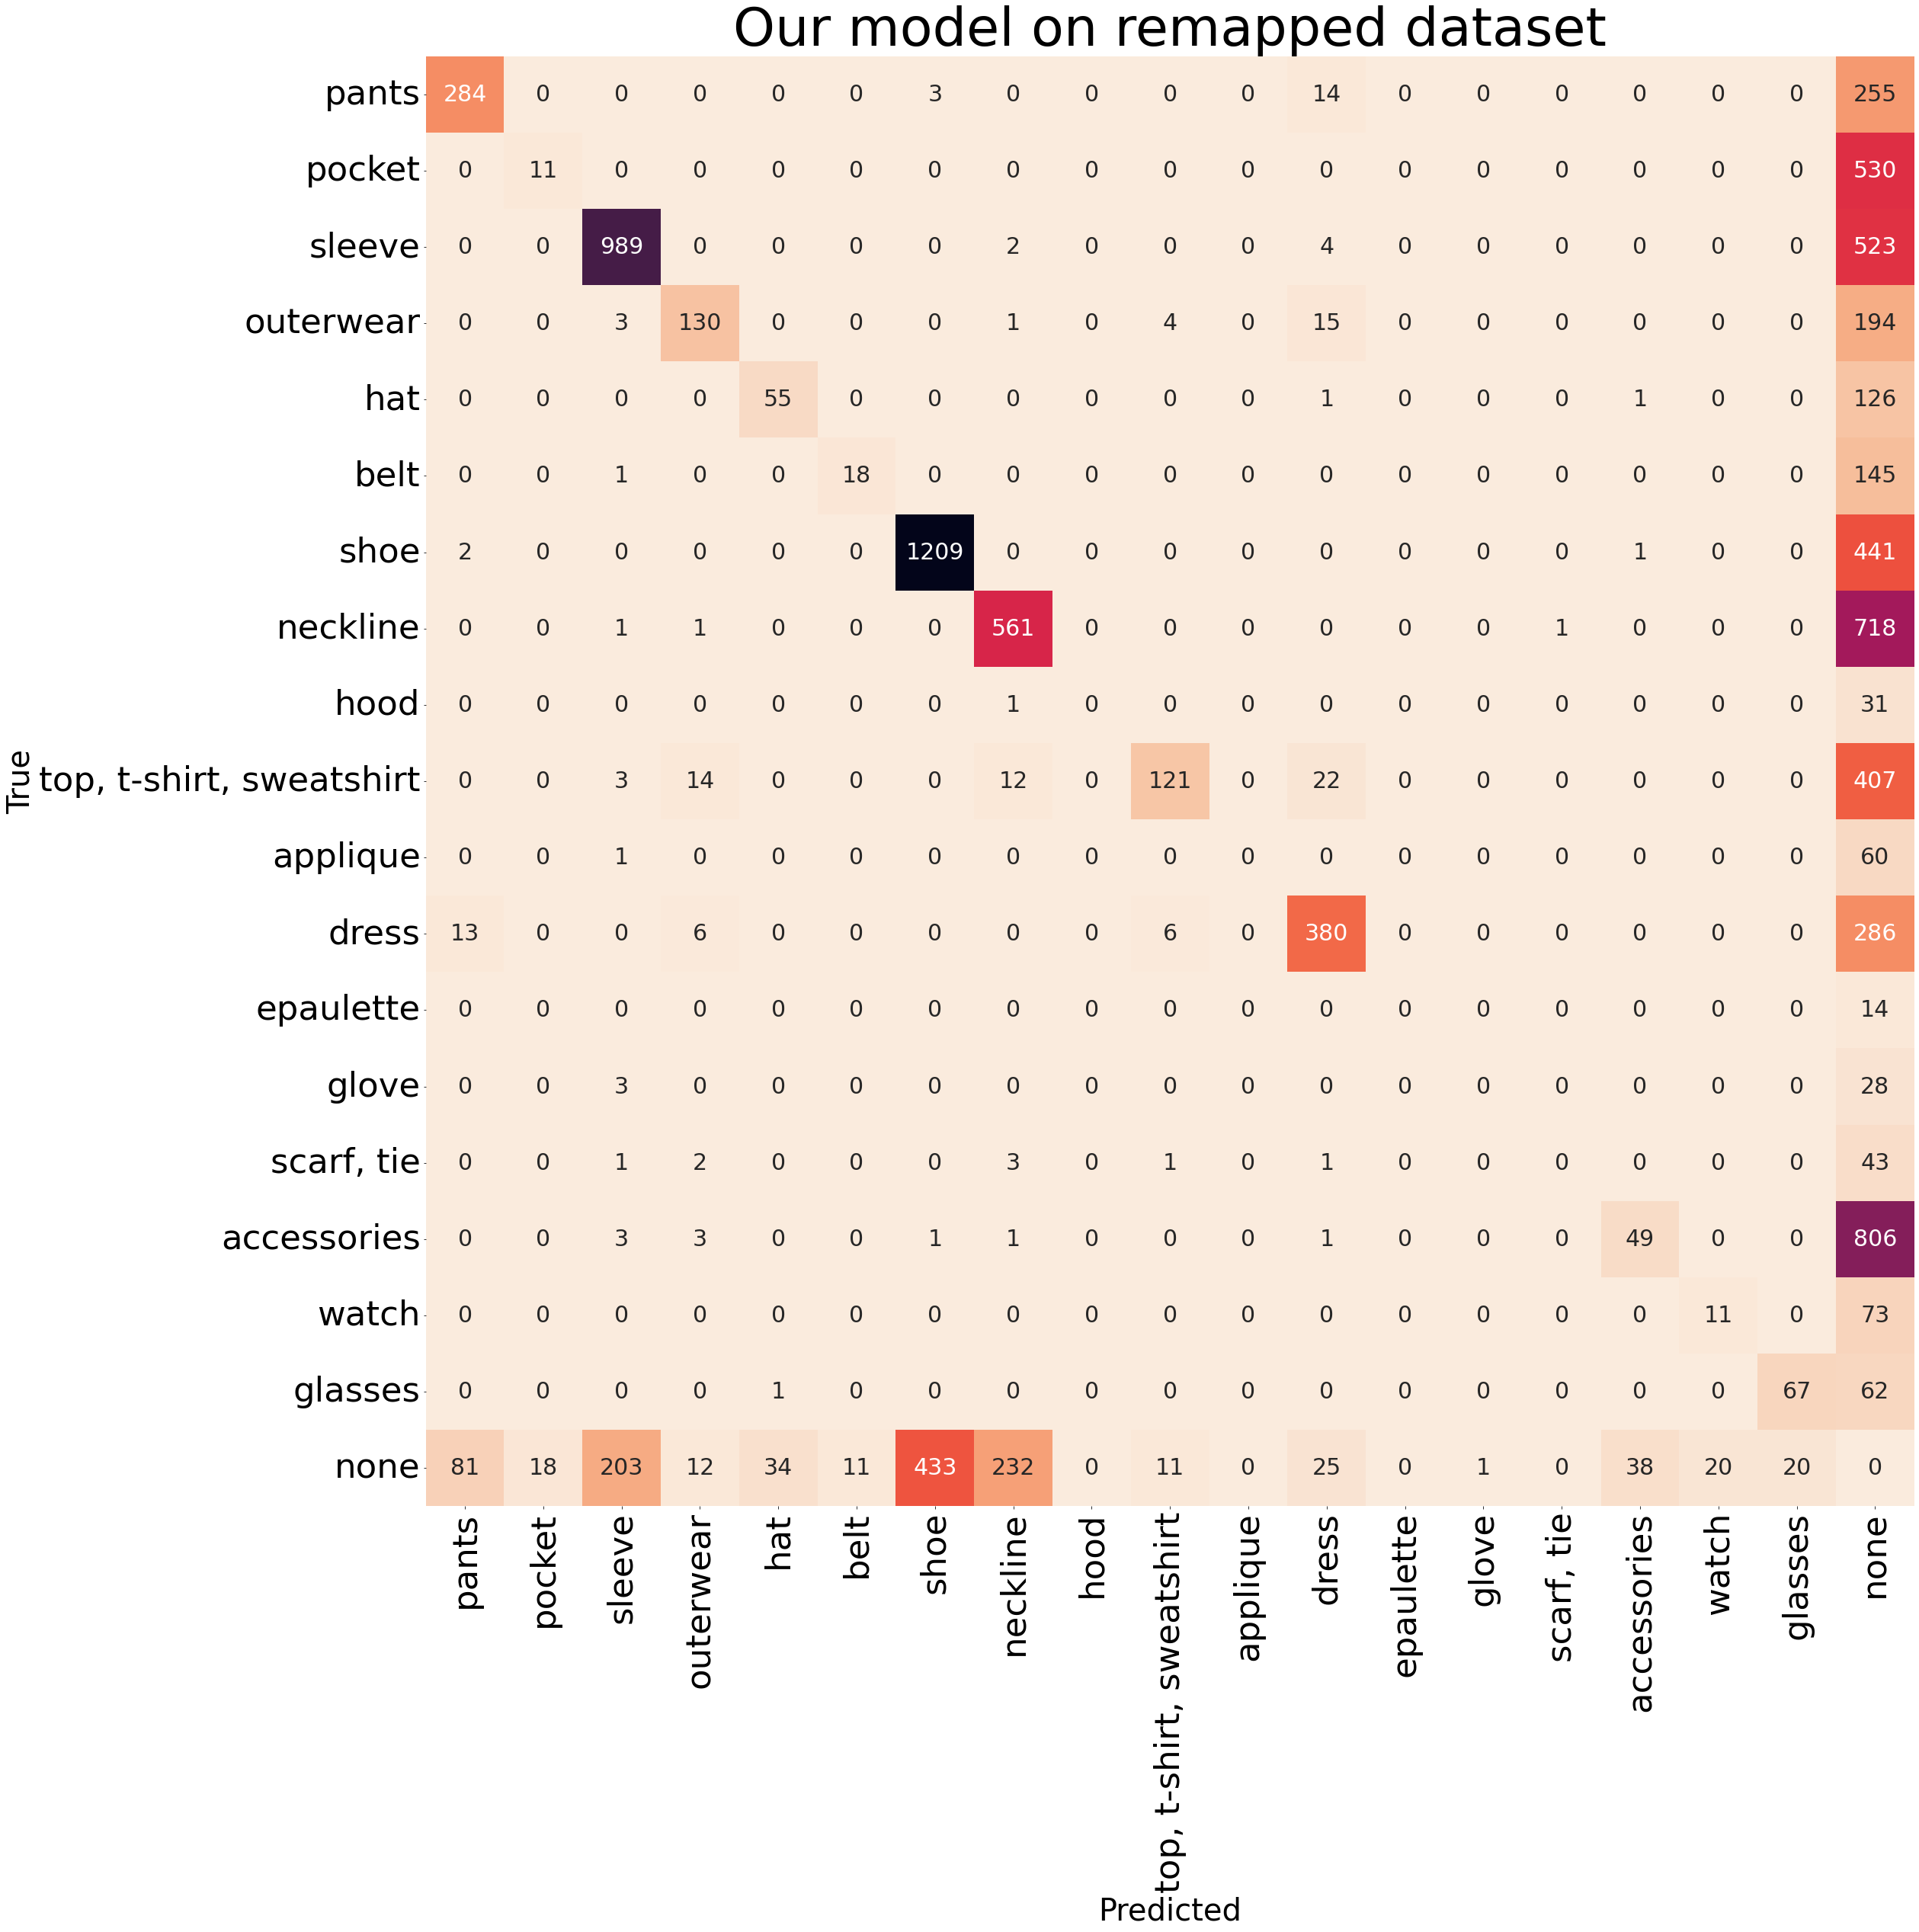

In [18]:
cm = pd.DataFrame(compute_confusion_matrix(metrics_remapped_noh, LABEL_DICT_REVERSE, 0.4),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False,
           annot_kws={'size': 30})
plt.xlabel("Predicted", fontsize=40)
plt.ylabel("True", fontsize=40)
plt.xticks(fontsize=45, rotation=90)
plt.yticks(fontsize=45, rotation=0)
plt.title("Our model on remapped dataset", fontsize=70)
plt.show() # remapped

# Spanish dataset model

In [11]:
full_data = datasets.load_from_disk("data/")
es = datasets.load_dataset("adam-narozniak/clothing")

Loading dataset from disk:   0%|          | 0/48 [00:00<?, ?it/s]

In [12]:
MODEL = transformers.YolosForObjectDetection.from_pretrained('checkpoint-44000', local_files_only=True)
LABEL_DICT, LABEL_DICT_REVERSE = create_label_dict(es["train"].features['objects'].feature['category'].names)
DATASET = full_data['test']

In [26]:
metrics_spanish_noh = assess_model(DATASET, LABEL_DICT, detect_boxes, threshold=0.85)

100%|██████████| 334/334 [18:31<00:00,  3.33s/it]


In [27]:
fnps_spanish_noh = calculate_positives_negatives(metrics_spanish_noh, LABEL_DICT.values(), threshold=0.4)
write_fnp_dict(fnps_spanish_noh, "fnps_spanish_noh")

In [28]:
prec, rec = average_scores(metrics_spanish_noh, fnps_spanish_noh)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.6640720734118714
Average recall= 0.5064420218037661


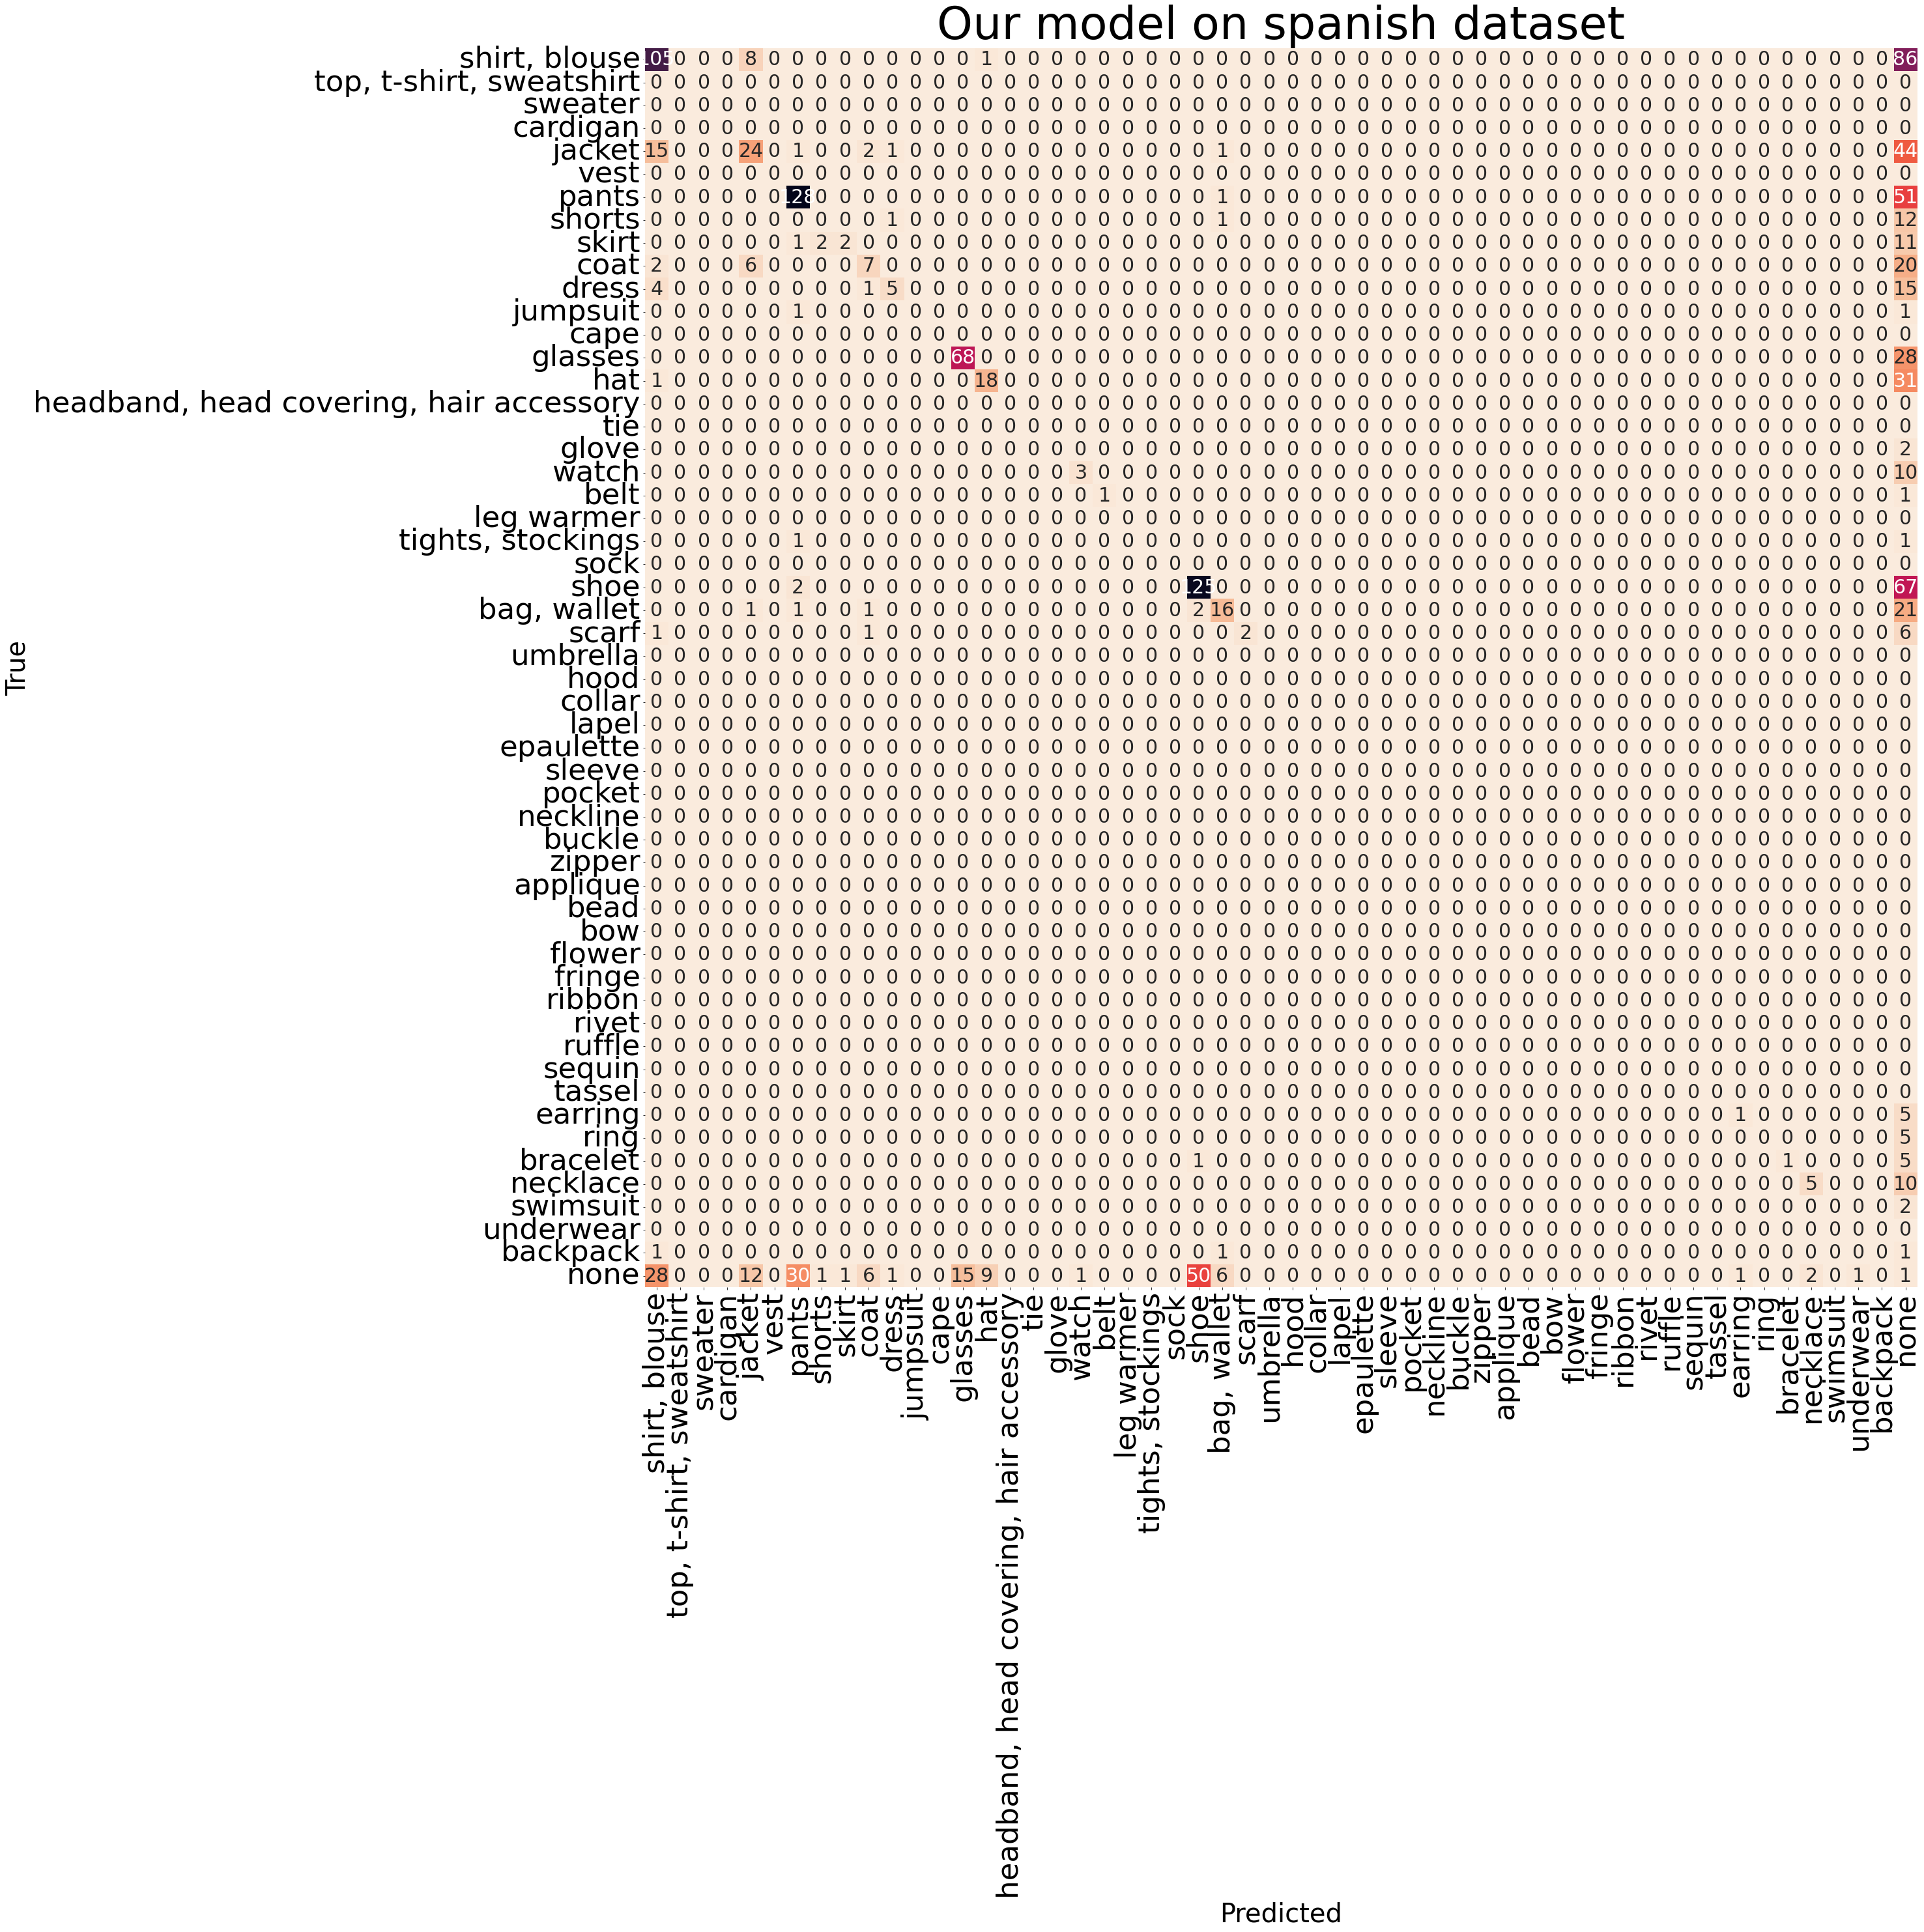

In [24]:
cm = pd.DataFrame(compute_confusion_matrix(metrics_spanish_noh, LABEL_DICT_REVERSE, 0.4),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False,
           annot_kws={'size': 30})
plt.xlabel("Predicted", fontsize=40)
plt.ylabel("True", fontsize=40)
plt.xticks(fontsize=45, rotation=90)
plt.yticks(fontsize=45, rotation=0)
plt.title("Our model on spanish dataset", fontsize=70)
plt.show()

# Experiments

In [13]:
def assess_model(dataset, label_dict, detection_method, k=None, **kwargs):
    # compute matching labels, IOUs and bounding box scores for all elements of the dataset
    """
    Params:
    dataset -- dataset on which we are testing
    label_dict -- dictionary assigning indexes to classes
    detection_method -- bounding box detection method to use
    k -- k for top k assessment
    Returns (dict elements):
    labels_gt -- ground truth labels, as cloth item names. "None" means that there was a prediction, but no ground truth
    labels_p -- prediction labels, as cloth item names. "None" means that there was ground truth, but no prediction (false negative)
    scores -- confidence scores of bounding boxes. 0 if box is missing
    iou -- IOU scores of bounding boxes. -1 if box is missing
    """
    assessment_dict = {
        "labels_gt":[],
        "labels_p":[],
        "scores":[],
        "iou":[]
    }
    for data in tqdm(dataset):
        if k is None:
            labels_gt, labels_p, scores, iou = compare_labels(data, detection_method(data['image'], **kwargs))
        else:
            labels_gt, labels_p, scores, iou = compare_labels_topk(data, detection_method(data['image'], **kwargs), k)
        assessment_dict['labels_gt'].extend(labels_gt)
        assessment_dict['labels_p'].extend(labels_p)
        assessment_dict['scores'].extend(scores)
        assessment_dict['iou'].extend(iou)
    
    labels_p, labels_gt = translate_labels(assessment_dict['labels_p'], assessment_dict['labels_gt'], label_dict)
    assessment_dict['labels_gt'] =  np.array(labels_gt)
    assessment_dict['labels_p'] = np.array(labels_p)
    assessment_dict['scores'] = np.array(assessment_dict['scores'])
    assessment_dict['iou'] = np.array(assessment_dict['iou'])
    return assessment_dict

In [14]:
def translate_labels(labels_p, labels_gt, label_dict):
    # translating labels into clothing names
    
    new_labels_p = []
    new_labels_gt = []
    for p, gt in zip(labels_p, labels_gt):
        if isinstance(p, np.ndarray) or isinstance(p, list):
            trans_p = []
            for p_ele in p:
                trans_p.append(label_dict[p_ele])
            new_labels_p.append(trans_p)
        else:
            new_labels_p.append(label_dict[p])
        new_labels_gt.append(label_dict[gt])
    return new_labels_p, new_labels_gt

In [15]:
import copy

def compare_labels(ground_truth, prediction):
    # function for matching labels between bounding boxes of given ground truths and predictions
    bb_gt = ground_truth['objects']['bbox']
    if torch.is_tensor(prediction['boxes']):
        bb_p = prediction['boxes'].detach().tolist()
    else:
        bb_p = prediction['boxes']
    labels_gt = ground_truth['objects']['category']
    if torch.is_tensor(prediction['labels']):
        labels_p = prediction['labels'].detach().tolist()
    else:
        labels_p = prediction['labels']
    if torch.is_tensor(prediction['scores']):
        scores_p = prediction['scores'].detach().numpy()
    else:
        scores_p = np.array(prediction['scores'])
    
    labels_matched_p = []
    labels_matched_gt = []
    ious = []
    
    # Situation in which we have no ground truths
    if len(labels_gt) == 0:
        for label in labels_p:
            labels_matched_p.append(label)
            labels_matched_gt.append(-1)
            ious.append(-1)
        return labels_matched_gt, labels_matched_p, scores_p, ious
    
    # Situation in which we have no predictions
    if len(labels_p) == 0:
        scores_p = scores_p.tolist()
        for label in labels_gt:
            labels_matched_gt.append(label)
            labels_matched_p.append(-1)
            scores_p.append(0)
            ious.append(-1)
        return labels_matched_gt, labels_matched_p, scores_p, ious
    
    iou_matrix = np.zeros((len(bb_p), len(bb_gt)))
    for i in range(len(bb_p)):
        for j in range(len(bb_gt)):
            iou_matrix[i, j] = calculate_iou(bb_p[i], bb_gt[j])
    
    max_cost = iou_matrix[np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)]
    
    len_diff = len(bb_p) - len(bb_gt)
    if len_diff > 0: # adding padding if there are more predictions than ground truths
        iou_matrix = np.c_[iou_matrix, np.zeros((len(bb_p), len_diff)) + max_cost]
        for i in range(len_diff):
            labels_gt.append(-1)
    
    cost_matrix = max_cost - iou_matrix
    m = Munkres()
    optimal_idxes = m.compute(cost_matrix)
    used_idxes_p = []
    used_idxes_gt = []
    
    for (i_p, i_gt) in optimal_idxes:
        # adding matching labels
        labels_matched_p.append(labels_p[i_p])
        labels_matched_gt.append(labels_gt[i_gt])
        # removing used indexes
        used_idxes_gt.append(i_gt)
        used_idxes_p.append(i_p)
        # adding appropriate iou scores
        ious.append(iou_matrix[(i_p, i_gt)])
        
    # appending leftover predictions
    for i, p in enumerate(labels_p):
        if i in used_idxes_p:
            continue
        labels_matched_p.append(p)
        labels_matched_gt.append(-1)
        used_idxes_p.append(i)
        ious.append(-1)
        
    # rearranging scores
    scores_p = scores_p[used_idxes_p].tolist()

    # appending leftover ground truths
    for i, gt in enumerate(labels_gt):
        if i in used_idxes_gt:
            continue
        labels_matched_p.append(-1)
        labels_matched_gt.append(gt)
        ious.append(-1)
        scores_p.append(0)
    
    return labels_matched_gt, labels_matched_p, scores_p, ious


def compare_labels_topk(ground_truth, prediction, k):
    # function for matching labels between bounding boxes of given ground truths and predictions
    bb_gt = ground_truth['objects']['bbox']
    if torch.is_tensor(prediction['boxes']):
        bb_p = prediction['boxes'].detach().numpy()
    else:
        bb_p = np.array(prediction['boxes'])
    labels_gt = ground_truth['objects']['category']
    if torch.is_tensor(prediction['labels']):
        labels_p = prediction['labels'].detach().numpy()
    else:
        labels_p = np.array(prediction['labels'])
    if torch.is_tensor(prediction['scores']):
        scores_p = prediction['scores'].detach().numpy()
    else:
        scores_p = np.array(prediction['scores'])
    
    labels_matched_p = []
    labels_matched_gt = []
    ious = []
    scores = []
    
    # Situation in which we have no ground truths
    if len(labels_gt) == 0:
        for i, label in enumerate(labels_p):
            labels_matched_p.append(np.array([label]))
            labels_matched_gt.append(-1)
            ious.append([-1])
            scores.append([scores_p[i]])
        return labels_matched_gt, labels_matched_p, scores_p, ious
    
    # Situation in which we have no predictions
    if len(labels_p) == 0:
        scores = [[s] for s in scores_p]
        for label in labels_gt:
            labels_matched_gt.append(label)
            labels_matched_p.append(np.array([-1]))
            scores.append([0])
            ious.append([-1])
        return labels_matched_gt, labels_matched_p, scores, ious
    
    iou_matrix = np.zeros((len(bb_p), len(bb_gt)))
    for i in range(len(bb_p)):
        for j in range(len(bb_gt)):
            iou_matrix[i, j] = calculate_iou(bb_p[i], bb_gt[j])

    max_cost = iou_matrix[np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)]
    iou_matrix2 = copy.deepcopy(iou_matrix)
    len_diff = len(bb_p) - len(bb_gt)
    if len_diff > 0: # adding padding if there are more predictions than ground truths
        iou_matrix2 = np.c_[iou_matrix2, np.zeros((len(bb_p), len_diff)) + max_cost]
        for i in range(len_diff):
            labels_gt.append(-1)
    
    cost_matrix = max_cost - iou_matrix2
    m = Munkres()
    optimal_idxes = m.compute(cost_matrix)
    used_idxes_p = []
    used_idxes_gt = []
    
    
    used_idxes_p = []
    for j in range(iou_matrix.shape[1]):
        # getting top k matched labels for each ground truth
        idxes = np.argsort(iou_matrix[:,j])[::-1][:(k-1)].tolist()
        for (i_p, i_gt) in optimal_idxes:
            if i_gt == j:
                idxes = [i_p] + idxes
        used_idxes_p.extend(idxes)
        labels_matched_p.append(labels_p[idxes])
        labels_matched_gt.append(labels_gt[j])
        ious.append(iou_matrix[:,j][idxes])
        scores.append(scores_p[idxes])

        
    # appending leftover predictions
    for i, p in enumerate(labels_p):
        if i in used_idxes_p:
            continue
        labels_matched_p.append([p])
        labels_matched_gt.append(-1)
        used_idxes_p.append(i)
        ious.append([-1])
        scores.append([scores_p[i]])
        

    return labels_matched_gt, labels_matched_p, scores, ious



In [16]:
def calculate_positives_negatives_topk(metrics, classes, threshold=0.5):
    # calculates the number of true/false positives and false negatives for each class
    fnp_dict = {
        key:{
            "false positives":0,
            "true positives":0,
            "false negatives":0

        } for key in classes
    }

    for p, gt, iou in zip(metrics['labels_p'], metrics['labels_gt'], metrics['iou']):
        if p[0] == "none" and gt != "none":
            fnp_dict[gt]['false negatives'] += 1
            continue
        if p[0] != "none" and gt == "none":
            fnp_dict[p[0]]['false positives'] += 1
            continue
        for p_ele, i in zip(p, iou):
            if p_ele == gt and i > threshold:
                fnp_dict[p_ele]['true positives'] += 1
                break
        else:
            fnp_dict[p[0]]['false positives'] += 1
            fnp_dict[gt]['false negatives'] += 1
    return fnp_dict



def compute_confusion_matrix_topk(metrics, label_dict_reverse, threshold=0.4):
    # compute confusion matrix for a given metrics dict
    # threshold -- IOU threshold
    confusion_matrix = np.zeros((len(label_dict_reverse), len(label_dict_reverse)))
    for p, gt, iou in zip(metrics['labels_p'], metrics['labels_gt'], metrics['iou']):
        row = label_dict_reverse[gt]
        col = label_dict_reverse[p]
        if iou > threshold or iou == -1:
            confusion_matrix[row, col] += 1
        else:
            confusion_matrix[row, -1] += 1
            confusion_matrix[-1, col] += 1
    return confusion_matrix

In [17]:
metrics_spanish_noh_top3 = assess_model(DATASET, LABEL_DICT, detect_boxes, k=3, threshold=0.85)

100%|██████████| 334/334 [18:35<00:00,  3.34s/it]
C:\Users\jakub\AppData\Local\Temp\ipykernel_6780\1127447921.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  assessment_dict['labels_p'] = np.array(labels_p)
C:\Users\jakub\AppData\Local\Temp\ipykernel_6780\1127447921.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  assessment_dict['scores'] = np.array(assessment_dict['scores'])
C:\Users\jakub\AppData\Local\Temp\ipykernel_6780\1127447921.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

In [18]:
fnps_spanish_noh_top3 = calculate_positives_negatives_topk(metrics_spanish_noh_top3, LABEL_DICT.values(), threshold=0.4)
write_fnp_dict(fnps_spanish_noh_top3, "fnps_spanish_noh_top3_2")

In [32]:
metrics_spanish_noh['labels_gt'][0:5]

array(['shoe', 'shirt, blouse', 'pants', 'shoe', 'none'], dtype='<U17')

In [30]:
metrics_spanish_noh['labels_p'][0:5]

array(['shoe', 'shirt, blouse', 'pants', 'shoe', 'jacket'], dtype='<U13')

In [33]:
metrics_spanish_noh_top3['labels_gt'][0:5]

array(['shoe', 'shirt, blouse', 'pants', 'shoe', 'shoe'], dtype='<U17')

In [31]:
metrics_spanish_noh_top3['labels_p'][0:5]

array([list(['shoe', 'shoe', 'pants']),
       list(['shirt, blouse', 'shirt, blouse', 'pants']),
       list(['pants', 'pants', 'shirt, blouse']),
       list(['shoe', 'shoe', 'pants']), list(['pants', 'pants', 'pants'])],
      dtype=object)

In [19]:
prec, rec = average_scores(metrics_spanish_noh_top3, fnps_spanish_noh_top3)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.5332862784122647
Average recall= 0.5094152626362736


In [54]:
prec, rec = average_scores(metrics_spanish_noh_top3, fnps_spanish_noh_top3)
print(f"Average precision= {prec}")
print(f"Average recall= {rec}")

Average precision= 0.5891285228081224
Average recall= 0.5857284440039643


In [ ]:
cm = pd.DataFrame(compute_confusion_matrix(metrics_spanish_noh_top3, LABEL_DICT_REVERSE, 0.4),
                 columns=list(LABEL_DICT.values()),
                 index=list(LABEL_DICT.values())
                 )

plt.figure(figsize=(35,35))

sns.heatmap(cm, annot=True, 
            fmt='.10g',
           cmap=sns.cm.rocket_r,
           cbar=False,
           annot_kws={'size': 30})
plt.xlabel("Predicted", fontsize=40)
plt.ylabel("True", fontsize=40)
plt.xticks(fontsize=45, rotation=90)
plt.yticks(fontsize=45, rotation=0)
plt.title("Our model on spanish dataset", fontsize=70)
plt.show()

In [59]:
# TRANSFORMING DATASET FOR SOFTWARE -- (used for producing plots)

import os
from tqdm import tqdm



IMAGE_PATH='metrics_data/images_remap' # path to which we save images from the dataset
ANNOTATIONS_PATH='metrics_data/annots_remap' # path to which we save ground truths from the dataset
DETECTION_PATH='metrics_data/dcs_remap' # path to which we save predictions 
CLASSES_PATH='metrics_data/fashion_remap.names' # path to file with all classes names

for path in [IMAGE_PATH, ANNOTATIONS_PATH, DETECTION_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

        
with open(CLASSES_PATH, "w") as f:
    for cls in LABEL_DICT.values():
        f.write(f"{cls}\n")        

for i, data in enumerate(tqdm(DATASET)):
    image = data['image']
    image.save(os.path.join(IMAGE_PATH, f"{i}.jpg")) # saving image
    results = detect_boxes(image) # model inference
    annotations = data['objects'] 
    width = data["width"]
    height = data["height"]
    boxes = center_bbox_xy(rescale_bboxes_to_img(annotations['bbox'], width, height))
    with open(os.path.join(ANNOTATIONS_PATH, f"{i}.txt"), "w") as f:
        for box, label in zip(boxes, annotations['category']): # saving ground truths
            f.write(f"{label} {box[0]} {box[1]} {box[2]} {box[3]}\n")
    
    idxes = np.argsort(results['scores'].detach().numpy())[::-1] # indexes for sorting by prediction score
    
    with open(os.path.join(DETECTION_PATH, f"{i}.txt"), "w") as f:
        for score, label, box in zip(results["scores"].detach().numpy()[idxes], \
                                     results["labels"].detach().numpy()[idxes], \
                                     results["boxes"].detach().numpy()[idxes]):
            f.write(f"{label} {score} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])}\n") # saving predictions

100%|██████████| 1158/1158 [1:10:48<00:00,  3.67s/it]


Software used for computing metrics: [Object detection metrics](https://github.com/rafaelpadilla/review_object_detection_metrics)